In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, mpld3
from mpld3 import plugins
%matplotlib inline
#mpld3.enable_notebook()

import csv
from scipy.optimize import curve_fit
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from datetime import date, timedelta
from scipy.fft import fft, ifft, fftfreq

# EDA

In [4]:
df = pd.read_csv('energy.dat')

In [5]:
df

,Date,Consumption
0,01-Apr-15,357.073
1,02-Apr-15,341.931
2,03-Apr-15,318.777
3,04-Apr-15,312.494
4,05-Apr-15,270.837
...,...,...
1822,27-Mar-20,237.171
1823,28-Mar-20,229.744
1824,29-Mar-20,297.636
1825,30-Mar-20,323.811


In [6]:
df.dtypes

Date            object
Consumption    float64
dtype: object

In [7]:
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
df.dtypes

Date           datetime64[ns]
Consumption           float64
dtype: object

In [9]:
df = df.rename(columns={'Date':'ds','Consumption':'ts'})

In [10]:
df.shape

(1827, 2)

Text(0, 0.5, 'consumption')

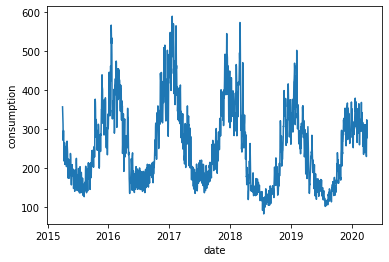

In [11]:
plt.figure()
plt.plot(df.ds, df.ts)
plt.xlabel('date')
plt.ylabel('consumption')

In [12]:
def log_trans(df,ts): return df[ts].apply(lambda x:np.log(x))

In [13]:
df['ts_log']=log_trans(df,'ts')

In [14]:
df

,ds,ts,ts_log
0,2015-04-01,357.073,5.877940
1,2015-04-02,341.931,5.834609
2,2015-04-03,318.777,5.764492
3,2015-04-04,312.494,5.744585
4,2015-04-05,270.837,5.601517
...,...,...,...
1822,2020-03-27,237.171,5.468781
1823,2020-03-28,229.744,5.436966
1824,2020-03-29,297.636,5.695871
1825,2020-03-30,323.811,5.780160


# Training, validation, test split

In [15]:
# constructing training, validation and test sets
def data_train_validate_test(df, training_set_percent=0.7, validation_set_percent=0.15, seed=None):
  length = len(df.index)  #size of index of dataset
  training_set_end = int(training_set_percent * length)  #size of the training set
  validation_set_end = int(validation_set_percent * length) + training_set_end  #size of the validation set + training set
  training = df.loc[:training_set_end] #select random rows up to the size of the training set to form the training dataset
  validation = df.loc[training_set_end+1:validation_set_end] #select random rows up to the size of validation set to form the validation dataset
  test = df.loc[validation_set_end+1:] #The remaining rows from the validation set onwards to the end will be the test dataset
  return training, validation, test

In [16]:
# generate training, validation and test sets
df_training, df_validation, df_test = data_train_validate_test(df)

In [17]:
# check the shapes of the training, validation and test sets
df_training.shape, df_validation.shape, df_test.shape

((1279, 3), (274, 3), (274, 3))

In [18]:
# relabel the index terms to ds terms
df_training.index = df_training.ds 
df_validation.index = df_validation.ds
df_test.index = df_test.ds
pd.set_option('display.max_rows', 20)
df_training

,ds,ts,ts_log
ds,,,
2015-04-01,2015-04-01,357.073,5.877940
2015-04-02,2015-04-02,341.931,5.834609
2015-04-03,2015-04-03,318.777,5.764492
2015-04-04,2015-04-04,312.494,5.744585
2015-04-05,2015-04-05,270.837,5.601517
...,...,...,...
2018-09-26,2018-09-26,172.802,5.152146
2018-09-27,2018-09-27,155.628,5.047469
2018-09-28,2018-09-28,182.789,5.208332


In [19]:
df_validation

,ds,ts,ts_log
ds,,,
2018-10-01,2018-10-01,201.030,5.303454
2018-10-02,2018-10-02,226.232,5.421561
2018-10-03,2018-10-03,207.030,5.332864
2018-10-04,2018-10-04,180.827,5.197541
2018-10-05,2018-10-05,160.632,5.079116
...,...,...,...
2019-06-27,2019-06-27,169.050,5.130195
2019-06-28,2019-06-28,170.858,5.140833
2019-06-29,2019-06-29,151.068,5.017730


In [20]:
df_test

,ds,ts,ts_log
ds,,,
2019-07-02,2019-07-02,167.485,5.120894
2019-07-03,2019-07-03,169.206,5.131117
2019-07-04,2019-07-04,137.849,4.926159
2019-07-05,2019-07-05,129.581,4.864306
2019-07-06,2019-07-06,128.446,4.855509
...,...,...,...
2020-03-27,2020-03-27,237.171,5.468781
2020-03-28,2020-03-28,229.744,5.436966
2020-03-29,2020-03-29,297.636,5.695871


# Decomposing the signal, Dickey-Fuller tests and testing for stationarity

In [21]:
def plot_decomposition(df,ts,trend,seasonal,residual):
  f, ((ax1,ax2),(ax3,ax4))=plt.subplots(2,2, figsize=(15,5), sharex=True)

  ax1.plot(df[ts],label="Original")
  ax1.legend(loc ='best')
  ax1.tick_params(axis ='x', rotation=45)

  ax2.plot(df[trend],label="Trend")
  ax2.legend(loc ='best')
  ax2.tick_params(axis='x', rotation=45)

  ax3.plot(df[seasonal],label="Seasonal")
  ax3.legend(loc ='best')
  ax3.tick_params(axis='x', rotation=45)

  ax4.plot(df[residual],label="Residuals")
  ax4.legend(loc = 'best')
  ax4.tick_params(axis='x', rotation=45)
  plt.tight_layout()

  plt.show()


In [22]:
# given that the interval between data points was by day, the decomposition period was taken as 365

In [23]:
def decomposition(df,ts, period, extrapolate_trend):
    decomposition = seasonal_decompose(df[ts], period=period, extrapolate_trend=extrapolate_trend)
    New_df = df.copy()
    New_df.loc[:,'trend'] = decomposition.trend
    New_df.loc[:,'seasonal'] = decomposition.seasonal
    New_df.loc[:,'residuals'] = decomposition.resid
    return New_df

In [24]:
New_DF_training = decomposition(df_training, 'ts_log', period= 365, extrapolate_trend=1)
New_DF_training

,ds,ts,ts_log,trend,seasonal,residuals
ds,,,,,,
2015-04-01,2015-04-01,357.073,5.877940,5.558593,0.123204,0.196143
2015-04-02,2015-04-02,341.931,5.834609,5.558451,0.129261,0.146897
2015-04-03,2015-04-03,318.777,5.764492,5.558310,0.034810,0.171372
2015-04-04,2015-04-04,312.494,5.744585,5.558168,-0.031844,0.218261
2015-04-05,2015-04-05,270.837,5.601517,5.558026,0.035628,0.007862
...,...,...,...,...,...,...
2018-09-26,2018-09-26,172.802,5.152146,5.241861,-0.137478,0.047764
2018-09-27,2018-09-27,155.628,5.047469,5.240872,-0.123639,-0.069765
2018-09-28,2018-09-28,182.789,5.208332,5.239882,-0.127714,0.096164


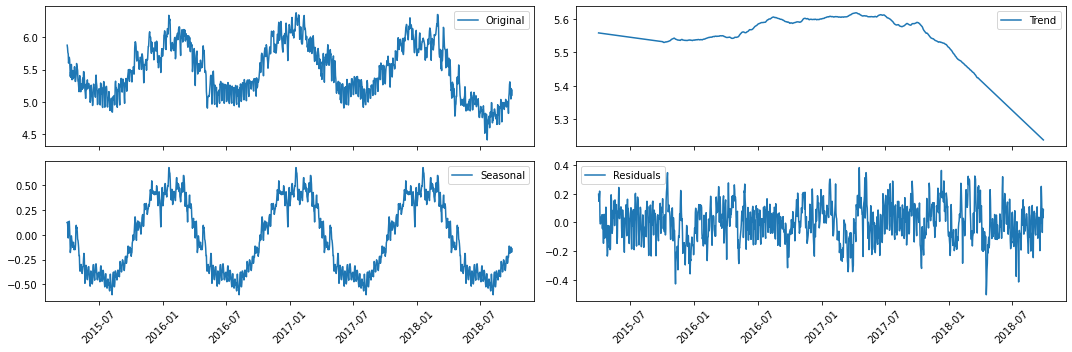

In [25]:
plot_decomposition(New_DF_training,'ts_log',trend='trend', seasonal='seasonal',residual='residuals')

In [26]:
def test_stationary(df, ts):
  #determine Rolling Statistics
  rolmean = df[ts].rolling(window=12, center = False).mean()
  rolstd = df[ts].rolling(window=12, center = False).std()

  orig = plt.plot(df[ts],color='blue',label='Original')
  mean = plt.plot(rolmean,color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label='Rolling StD')

  plt.legend(loc='best')
  plt.title('Rolling Mean and Standard Deviation for %s' %(ts))
  plt.xticks(rotation =45)
  plt.show(block =False)
  plt.close

  #Dickey-Fuller test: Null Hypothesis (H_0): time series is not stationary
  #Alternate Hypothesis(H_1): time series is stationary 
  #p-value is the probability of an observed (or more extreme) result assuming that the null hypothesis is true 
  #if p-value is less than 0.05 then reject null hypothesis   


  print('Results:')
  dftest = adfuller(df[ts],autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index =['Test Statistic','p-value','# Lags Used','Number of Observations'])

  for key, value in dftest[4].items():
    dfoutput['Critical value(%s)' %key]= value

  print(dfoutput)

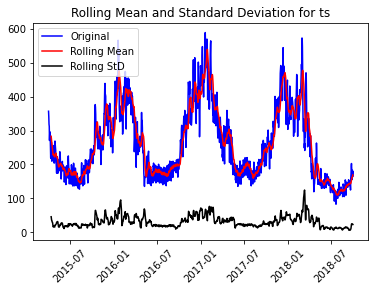

Results:
Test Statistic              -1.997251
p-value                      0.287780
# Lags Used                 23.000000
Number of Observations    1255.000000
Critical value(1%)          -3.435571
Critical value(5%)          -2.863846
Critical value(10%)         -2.567998
dtype: float64


In [27]:
# test for stationarity on the full signal
test_stationary(New_DF_training,'ts')

- therefore when carrying out Dickey-Fuller test on full signal, we see that the p-value is greater than 0.05 hence we accept the null hypothesis that the time series is not stationary i.e. the mean and standard deviation are changing

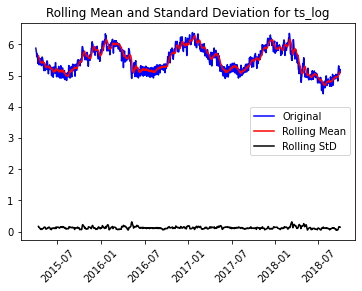

Results:
Test Statistic              -1.928100
p-value                      0.318960
# Lags Used                 23.000000
Number of Observations    1255.000000
Critical value(1%)          -3.435571
Critical value(5%)          -2.863846
Critical value(10%)         -2.567998
dtype: float64


In [28]:
# test for stationarity on the log of the full signal
test_stationary(New_DF_training,'ts_log')

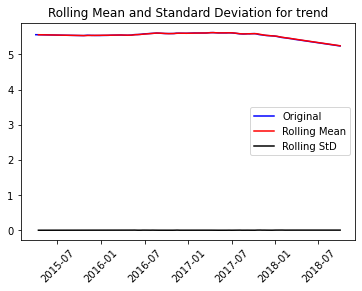

Results:
Test Statistic               2.086165
p-value                      0.998775
# Lags Used                 23.000000
Number of Observations    1255.000000
Critical value(1%)          -3.435571
Critical value(5%)          -2.863846
Critical value(10%)         -2.567998
dtype: float64


In [29]:
test_stationary(New_DF_training,'trend')

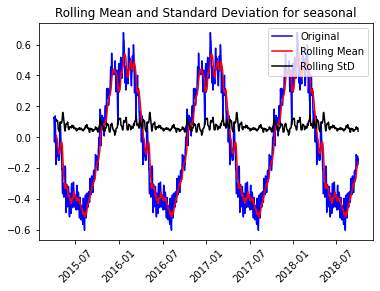

Results:
Test Statistic              -2.261727
p-value                      0.184609
# Lags Used                 22.000000
Number of Observations    1256.000000
Critical value(1%)          -3.435567
Critical value(5%)          -2.863844
Critical value(10%)         -2.567997
dtype: float64


In [30]:
test_stationary(New_DF_training,'seasonal')

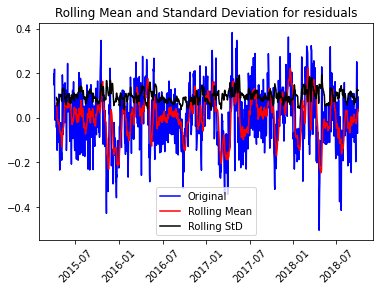

Results:
Test Statistic           -6.068533e+00
p-value                   1.165885e-07
# Lags Used               2.300000e+01
Number of Observations    1.255000e+03
Critical value(1%)       -3.435571e+00
Critical value(5%)       -2.863846e+00
Critical value(10%)      -2.567998e+00
dtype: float64


In [31]:
# test for stationarity on the residuals
test_stationary(New_DF_training, 'residuals')

- therefore when carrying out Dickey-Fuller test on the residuals, we see that the p-value is less than 0.05 hence we reject the null hypothesis that the time series is not stationary and accept the alternate hypothesis i.e. the mean and standard deviation are not changing

# curve fit to trend

In [32]:
# create a copy of the training set called 'New_DF_training_OLS' to curve fit onto the trend
New_DF_training_OLS = New_DF_training.copy()

In [33]:
# reset the index of the training set copy
New_DF_training_OLS.reset_index(drop=True, inplace=True)

In [34]:
# create a separate column called index which is the index of the training set copy
New_DF_training_OLS['index'] = New_DF_training_OLS.index

In [35]:
# add 1 to each term in the index column
New_DF_training_OLS['index'] += 1

In [36]:
New_DF_training_OLS.index = New_DF_training_OLS['ds']
New_DF_training_OLS

,ds,ts,ts_log,trend,seasonal,residuals,index
ds,,,,,,,
2015-04-01,2015-04-01,357.073,5.877940,5.558593,0.123204,0.196143,1
2015-04-02,2015-04-02,341.931,5.834609,5.558451,0.129261,0.146897,2
2015-04-03,2015-04-03,318.777,5.764492,5.558310,0.034810,0.171372,3
2015-04-04,2015-04-04,312.494,5.744585,5.558168,-0.031844,0.218261,4
2015-04-05,2015-04-05,270.837,5.601517,5.558026,0.035628,0.007862,5
...,...,...,...,...,...,...,...
2018-09-26,2018-09-26,172.802,5.152146,5.241861,-0.137478,0.047764,1275
2018-09-27,2018-09-27,155.628,5.047469,5.240872,-0.123639,-0.069765,1276
2018-09-28,2018-09-28,182.789,5.208332,5.239882,-0.127714,0.096164,1277


In [37]:
# turn 'index' column into a numpy array and make it the X 
X = New_DF_training_OLS['index'].to_numpy()

In [38]:
# turn 'trend' column into a numpy array and make it the y
y = New_DF_training_OLS['trend'].to_numpy()

In [39]:
# do a polynomial fit of X values against y values
z = np.polyfit(X, y, 5)

In [40]:
z

array([ 1.47429926e-15, -4.24576878e-12,  3.26605470e-09, -4.20014269e-07,
       -1.20486673e-04,  5.55758380e+00])

In [41]:
p = np.poly1d(z)

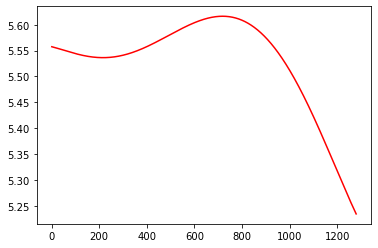

In [42]:
plt.plot(X, p(X), color='red')

<Figure size 432x288 with 0 Axes>

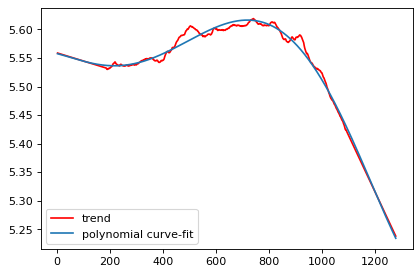

In [43]:
# plot the trend from the training set and overlap plot of the polyfit  
plt.figure()
plt.figure(figsize=(6, 4), dpi=80)
plot_1, = plt.plot(X, y, color='red', label ='trend')
plot_2, = plt.plot(X, p(X), label ='polynomial curve-fit')
plt.legend(handles=[plot_1, plot_2])
plt.show()

# ARIMA model

In [44]:
def run_Arima(df,ts,p, d, q):
  model=ARIMA(df[ts], order=(p,d,q))
  results_arima=model.fit()#(disp=-1)

  len_results=len(results_arima.fittedvalues)
  ts_modified=df[ts][-len_results:]

  rss = sum((results_arima.fittedvalues-ts_modified)**2)
  rmse=np.sqrt(rss/len(df[ts]))
  print('rmse:',rmse)
  plt.figure()
  plt.xticks(rotation =45)
  plt.plot(df[ts])
  plt.plot(results_arima.fittedvalues, color='red')

  plt.show()

  return results_arima

In [45]:
New_DF_training=New_DF_training.fillna(value=0)

## Run ARIMA on the residuals

C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


rmse: 0.0708227228366154


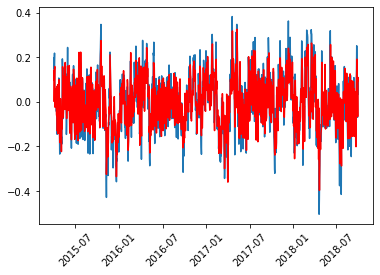

In [48]:
model_AR=run_Arima(df=New_DF_training,ts='residuals',p=23,d=0,q=0)

In [49]:
my_forecast = model_AR.forecast(274)

In [50]:
my_forecast

2018-10-01    0.140512
2018-10-02    0.090061
2018-10-03    0.006596
2018-10-04   -0.073557
2018-10-05   -0.030530
                ...   
2019-06-27    0.004001
2019-06-28    0.003859
2019-06-29    0.002308
2019-06-30    0.003148
2019-07-01    0.004235
Freq: D, Name: predicted_mean, Length: 274, dtype: float64

<Figure size 432x288 with 0 Axes>

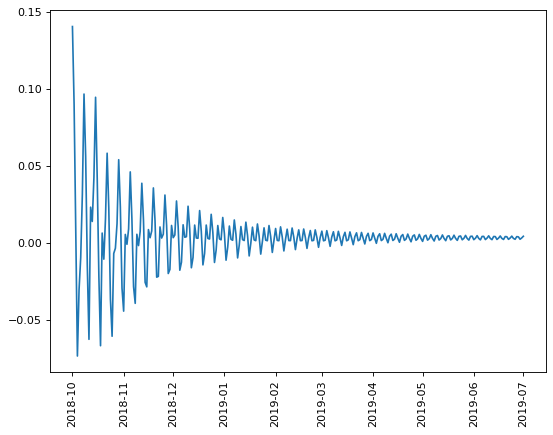

In [51]:
plt.figure()
plt.figure(figsize=(8, 6), dpi=80)
plt.xticks(rotation=90)
plt.plot(my_forecast)

In [52]:
# saving the ARIMA model of the log of the full signal
#model_AR.save('ARIMA_model_forecast_residuals(train=0.7pc, p=23, freq=365).pkl')

In [53]:
#load trained model 
#model_AR = ARIMAResults.load('ARIMA_model_forecast_residuals(train=0.7pc, p=150, freq=365).pkl')

## Compare residuals prediction to residuals from validation set

In [54]:
#check validation set
df_validation

,ds,ts,ts_log
ds,,,
2018-10-01,2018-10-01,201.030,5.303454
2018-10-02,2018-10-02,226.232,5.421561
2018-10-03,2018-10-03,207.030,5.332864
2018-10-04,2018-10-04,180.827,5.197541
2018-10-05,2018-10-05,160.632,5.079116
...,...,...,...
2019-06-27,2019-06-27,169.050,5.130195
2019-06-28,2019-06-28,170.858,5.140833
2019-06-29,2019-06-29,151.068,5.017730


In [55]:
New_DF_validation = decomposition(df_validation, 'ts_log', period= 45, extrapolate_trend=1)

In [56]:
New_DF_validation

,ds,ts,ts_log,trend,seasonal,residuals
ds,,,,,,
2018-10-01,2018-10-01,201.030,5.303454,5.153987,0.006885,0.142582
2018-10-02,2018-10-02,226.232,5.421561,5.161311,0.014637,0.245613
2018-10-03,2018-10-03,207.030,5.332864,5.168635,0.000801,0.163428
2018-10-04,2018-10-04,180.827,5.197541,5.175959,0.021365,0.000217
2018-10-05,2018-10-05,160.632,5.079116,5.183283,0.021032,-0.125198
...,...,...,...,...,...,...
2019-06-27,2019-06-27,169.050,5.130195,4.928078,0.017844,0.184273
2019-06-28,2019-06-28,170.858,5.140833,4.921107,0.006885,0.212840
2019-06-29,2019-06-29,151.068,5.017730,4.914137,0.014637,0.088956


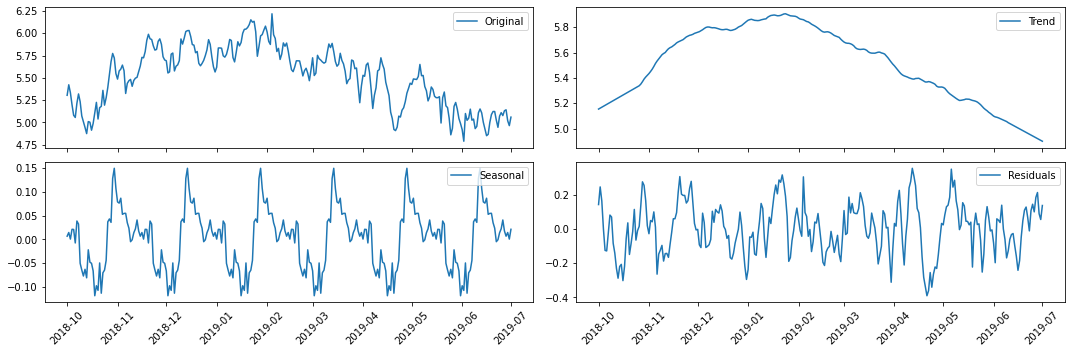

In [57]:
plot_decomposition(New_DF_validation,'ts_log',trend='trend', seasonal='seasonal',residual='residuals')

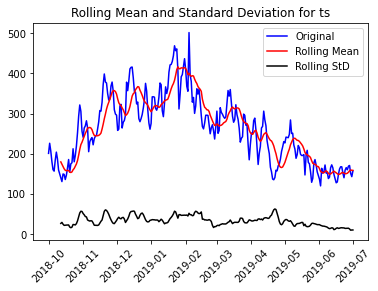

Results:
Test Statistic             -1.786610
p-value                     0.387129
# Lags Used                 9.000000
Number of Observations    264.000000
Critical value(1%)         -3.455365
Critical value(5%)         -2.872551
Critical value(10%)        -2.572638
dtype: float64


In [58]:
# test for stationarity on the full signal of the validation set
test_stationary(New_DF_validation,'ts')

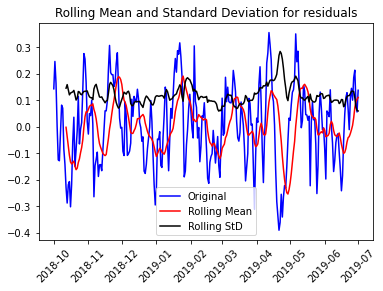

Results:
Test Statistic           -6.305264e+00
p-value                   3.335562e-08
# Lags Used               8.000000e+00
Number of Observations    2.650000e+02
Critical value(1%)       -3.455270e+00
Critical value(5%)       -2.872509e+00
Critical value(10%)      -2.572615e+00
dtype: float64


In [59]:
# test for stationarity on the noise of the validation set
test_stationary(New_DF_validation,'residuals')

In [60]:
start = len(New_DF_training)
end = len(New_DF_training)+len(New_DF_validation)-1
pred = model_AR.predict(start=start, end=end).rename('ARIMA Predictions')
pred_DF = pd.DataFrame(pred)
pred_DF['Date']=pred_DF.index

In [61]:
pred_DF #ARIMA forecasts of consumption

,ARIMA Predictions,Date
2018-10-01,0.140512,2018-10-01
2018-10-02,0.090061,2018-10-02
2018-10-03,0.006596,2018-10-03
2018-10-04,-0.073557,2018-10-04
2018-10-05,-0.030530,2018-10-05
...,...,...
2019-06-27,0.004001,2019-06-27
2019-06-28,0.003859,2019-06-28
2019-06-29,0.002308,2019-06-29
2019-06-30,0.003148,2019-06-30


In [62]:
sdate = '2018-10-01'
edate = '2019-07-01'
date_list = pd.date_range(sdate, edate, periods=274).tolist()

Text(0, 0.5, 'consumption')

<Figure size 432x288 with 0 Axes>

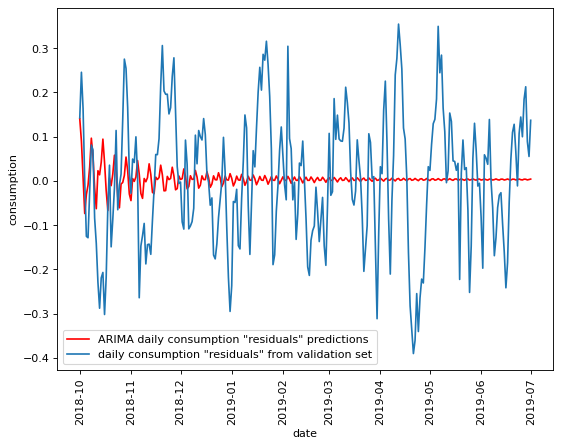

In [63]:
# plot ARIMA residuals forecast and validation set residuals
plt.figure()
plt.figure(figsize=(8, 6), dpi=80)
plot_1, = plt.plot(date_list, pred_DF['ARIMA Predictions'], color='red', label ='ARIMA daily consumption "residuals" predictions')
plot_2, = plt.plot(date_list, New_DF_validation['residuals'], label ='daily consumption "residuals" from validation set')
plt.legend(handles=[plot_1, plot_2])
plt.xticks(rotation=90)
plt.xlabel("date")
plt.ylabel("consumption")
#plt.ylim([-0.3, 0.3])

In [64]:
# calculate rmse error between ARIMA residuals forecast and vaildation set residuals
rss = sum((pred_DF['ARIMA Predictions']-New_DF_validation['residuals'])**2)
rmse=np.sqrt(rss/len(New_DF_validation['residuals']))
print('rmse:',rmse)

rmse: 0.1481765643650167


# Generating a forecast signal and comparing to the validation set

- sum residuals ARIMA forecast, with trend forecast from polyfit of training and seasonality extraction

In [65]:
# create the trend for the validation period from the polyfit coefficients generated from the training set
xp = np.linspace(0,274,274)
trend = p(xp)

# add the trend to the pred_DF dataframe
pred_DF['trend'] = trend.tolist()

# extract the seasonality from the training set i.e. the last 274 rows of the training set and add them as a column
# to pred_DF
training_seasonal = New_DF_training['seasonal'].iloc[926:1200]
pred_DF['seasonal'] = training_seasonal.tolist()

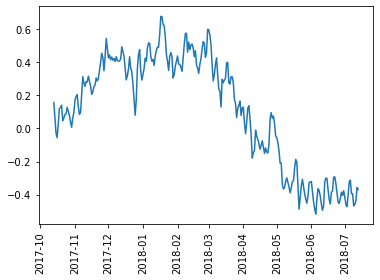

In [66]:
plt.xticks(rotation=90)
plt.plot(training_seasonal)

In [67]:
pred_DF

,ARIMA Predictions,Date,trend,seasonal
2018-10-01,0.140512,2018-10-01,5.557584,0.156632
2018-10-02,0.090061,2018-10-02,5.557462,0.069083
2018-10-03,0.006596,2018-10-03,5.557340,-0.027953
2018-10-04,-0.073557,2018-10-04,5.557217,-0.055426
2018-10-05,-0.030530,2018-10-05,5.557094,0.026053
...,...,...,...,...
2019-06-27,0.004001,2019-06-27,5.538270,-0.467982
2019-06-28,0.003859,2019-06-28,5.538343,-0.459033
2019-06-29,0.002308,2019-06-29,5.538417,-0.438166
2019-06-30,0.003148,2019-06-30,5.538492,-0.356803


In [68]:
# sum all the values from the trend, seasonal and ARIMA noise prediction
pred_DF['total_signal'] = pred_DF['ARIMA Predictions'] + pred_DF['trend'] + pred_DF['seasonal']

In [69]:
pred_DF

,ARIMA Predictions,Date,trend,seasonal,total_signal
2018-10-01,0.140512,2018-10-01,5.557584,0.156632,5.854728
2018-10-02,0.090061,2018-10-02,5.557462,0.069083,5.716606
2018-10-03,0.006596,2018-10-03,5.557340,-0.027953,5.535983
2018-10-04,-0.073557,2018-10-04,5.557217,-0.055426,5.428234
2018-10-05,-0.030530,2018-10-05,5.557094,0.026053,5.552616
...,...,...,...,...,...
2019-06-27,0.004001,2019-06-27,5.538270,-0.467982,5.074288
2019-06-28,0.003859,2019-06-28,5.538343,-0.459033,5.083168
2019-06-29,0.002308,2019-06-29,5.538417,-0.438166,5.102559
2019-06-30,0.003148,2019-06-30,5.538492,-0.356803,5.184837


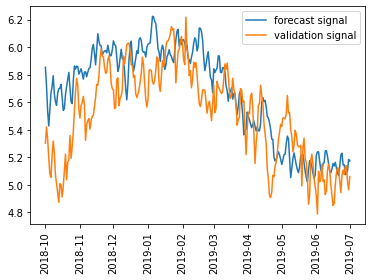

In [70]:
# plot the forecast signal along with the validation signal
plt.xticks(rotation=90)
plot_1, = plt.plot(pred_DF.Date, pred_DF.total_signal, label ='forecast signal')
plot_2, = plt.plot(New_DF_validation.ds, New_DF_validation.ts_log, label ='validation signal')
plt.legend(handles=[plot_1, plot_2])

In [71]:
# calculate rmse error between forecast and vaildation 
rss = sum((pred_DF['total_signal']-New_DF_validation['ts_log'])**2)
rmse=np.sqrt(rss/len(New_DF_validation['ts_log']))
print('rmse:',rmse)

rmse: 0.27601823081612553


# Signal processing of the training set to improve model performance

- From the original full (log) signal that was decomposed at a period of 365, subtract the seasonality component
- Look at the original full (log) signal now (which has had seasonality subtracted from it) and see if there remains any seasonality still
- If so further decomposition at other frequencies will be needed
- To find the magnitude and phase of the frequencies, apply FFT to the original full (log) signal

## Carry out FFT of training signal to identify discrete frequencies

Text(0.5, 0, 'date')

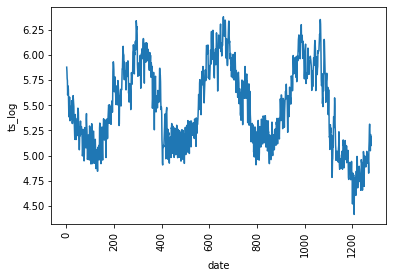

In [72]:
plt.xticks(rotation=90)
y = New_DF_training_OLS['ts_log'].to_numpy()
x = New_DF_training_OLS['index'].to_numpy()
plt.plot(x,y)
plt.ylabel('ts_log')
plt.xlabel('date')

In [73]:
# FFT on ts_log
yf = fft(y)
yf.shape

(1279,)

In [74]:
#plt.plot(x,yf)

In [75]:
# take the index, with periodicity of 1 day, and use to calculate the fft frequency but for half of the total 
# signal period since the signal is repeating
N = x.size
T = x[1] - x[0]
xf1 = fftfreq(N, T)
xf2 = fftfreq(N, T)[0:N//2]

In [76]:
# take half the fft(y) values (since fft signal is symetrical about x=0 ) and then multiply the half of the fft(y)
# values by 1/hlaf of the total signal period
zf = 2.0/N * np.abs(yf[0:N//2])
#zf =  np.abs(yf[0:N//2])

In [77]:
#fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8))
# plot the full fft(y)
#ax1.plot(xf1, yf)
#ax1.set_title('full fft(y)')
#ax1.set(xlabel='frequency', ylabel='fft(y)')

# plot the first half the values of fft(y)
#ax2.plot(xf2, zf)
#ax2.set_title('half fft(y)')
#ax2.set(xlabel='frequency', ylabel='fft(y)')

#plt.subplots_adjust(left=0.1,
#                    bottom=0.1, 
#                    right=0.9, 
#                    top=0.9, 
#                    wspace=0.4, 
#                    hspace=0.4)
#mpld3.display()

In [78]:
#!pip install mpld3
#!pip install "git+https://github.com/javadba/mpld3@display_fix"

In [80]:
plt.figure(figsize=(10, 4))
plt.plot(xf2, zf)
plt.xlabel('frequency')
plt.ylabel('fft(y)')
plt.ylim((0, 0.35))
plt.xlim((0, 0.45))
mpld3.display()

In [81]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(1//xf2, zf)
ax.set_xlabel('period')
ax.set_ylabel('reciprocal consumption')
plugins.connect(fig, plugins.MousePosition(fontsize=14))
mpld3.display()

<ipython-input-81-817913aa0ebf>:2: RuntimeWarning: divide by zero encountered in floor_divide
  ax.plot(1//xf2, zf)


7- key peaks (magnitude) from graph are at 365, 159, 106, 79, 47, 6, 3

In [77]:
#fig, ax = plt.subplots(figsize=(10, 4))
#ax.plot(np.log10(1//xf), zf)
#ax.set_xlabel('log_10 (period)')
#ax.set_ylabel('reciprocal consumption')
#plugins.connect(fig, plugins.MousePosition(fontsize=14))
#mpld3.display()

In [78]:
y_ifft = ifft(yf)

In [79]:
y_ifft

array([5.87794024-1.24442199e-15j, 5.83460896+9.49982860e-16j,
       5.7644918 +6.55543728e-16j, ..., 5.20833248-3.06661134e-15j,
       5.09673348-2.11107302e-15j, 5.18397216+3.27771864e-16j])

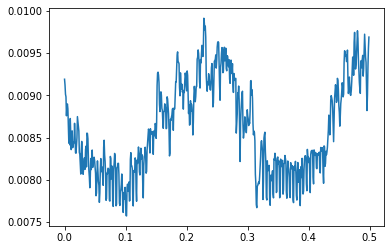

In [80]:
plt.plot(xf2, 2.0/N * np.abs(y_ifft[0:N//2]))
#plt.xlim(0,400)
#plt.ylim(0, 200)

## Remove seasonality from the log full signal and plot this signal

In [81]:
# New_DF_training_OLS['ts_log'] has been decomposed already at a period of 365 to produce trend, seasonal and residuals
# create a new column in copy of training set which is the full signal minus the seasonality component
New_DF_training_OLS['ts_log_minus_seasonal'] = New_DF_training_OLS['ts_log'] - New_DF_training_OLS['seasonal']

In [82]:
New_DF_training_OLS

,ds,ts,ts_log,trend,seasonal,residuals,index,ts_log_minus_seasonal
ds,,,,,,,,
2015-04-01,2015-04-01,357.073,5.877940,5.558593,0.123204,0.196143,1,5.754736
2015-04-02,2015-04-02,341.931,5.834609,5.558451,0.129261,0.146897,2,5.705348
2015-04-03,2015-04-03,318.777,5.764492,5.558310,0.034810,0.171372,3,5.729682
2015-04-04,2015-04-04,312.494,5.744585,5.558168,-0.031844,0.218261,4,5.776429
2015-04-05,2015-04-05,270.837,5.601517,5.558026,0.035628,0.007862,5,5.565889
...,...,...,...,...,...,...,...,...
2018-09-26,2018-09-26,172.802,5.152146,5.241861,-0.137478,0.047764,1275,5.289625
2018-09-27,2018-09-27,155.628,5.047469,5.240872,-0.123639,-0.069765,1276,5.171107
2018-09-28,2018-09-28,182.789,5.208332,5.239882,-0.127714,0.096164,1277,5.336047


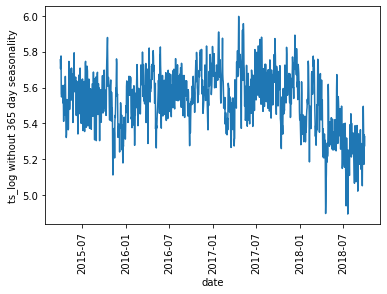

In [83]:
# plot ts_log without the 365 day seasonality 
plt.xticks(rotation=90)
plt.xlabel('date')
plt.ylabel('ts_log without 365 day seasonality')
plt.plot(New_DF_training_OLS['ds'], New_DF_training_OLS['ts_log_minus_seasonal'])

In [84]:
y_2 = New_DF_training_OLS['ts_log_minus_seasonal'].to_numpy()
x_2 = New_DF_training_OLS['index'].to_numpy()

In [85]:
# FFT on ts_log
yf_2 = fft(y_2)
yf_2.shape

(1279,)

In [86]:
#plt.plot(x,yf)

In [87]:
# take the index, with periodicity of 1 day, and use to calculate the fft frequency but for half of the total 
# signal period since the signal is repeating
N_2 = x_2.size
T_2 = x_2[1] - x_2[0]
xf1_2 = fftfreq(N_2, T_2)
xf2_2 = fftfreq(N_2, T_2)[0:N_2//2]

In [88]:
# take half the fft(y) values (since fft signal is symetrical about x=0 ) and then multiply the half of the fft(y)
# values by 1/hlaf of the total signal period
zf_2 = 2.0/N_2 * np.abs(yf_2[0:N_2//2])
#zf =  np.abs(yf[0:N//2])

In [89]:
#fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8))
# plot the full fft(y)
#ax1.plot(xf1, yf)
#ax1.set_title('full fft(y)')
#ax1.set(xlabel='frequency', ylabel='fft(y)')

# plot the first half the values of fft(y)
#ax2.plot(xf2, zf)
#ax2.set_title('half fft(y)')
#ax2.set(xlabel='frequency', ylabel='fft(y)')

#plt.subplots_adjust(left=0.1,
#                    bottom=0.1, 
#                    right=0.9, 
#                    top=0.9, 
#                    wspace=0.4, 
#                    hspace=0.4)
#mpld3.display()

In [90]:
#!pip install mpld3
#!pip install "git+https://github.com/javadba/mpld3@display_fix"

In [91]:
# plot fft of the full ,og signal without the 365 day seasonality
plt.figure(figsize=(10, 4))
plt.plot(xf2_2, zf_2)
plt.xlabel('frequency')
plt.ylabel('fft(y)')
plt.ylim((0, 0.35))
plt.xlim((0, 0.45))
mpld3.display()

In [92]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(1//xf2_2, zf_2)
ax.set_xlabel('period')
ax.set_ylabel('reciprocal consumption')
plugins.connect(fig, plugins.MousePosition(fontsize=14))
mpld3.display()

<ipython-input-92-e3389f74d422>:2: RuntimeWarning: divide by zero encountered in floor_divide
  ax.plot(1//xf2_2, zf_2)


## Decompose the 'ts_log_minus_seasonal' signal at a period of 182 

In [93]:
decomposition = seasonal_decompose(New_DF_training_OLS['ts_log_minus_seasonal'], period=182, extrapolate_trend=1)
New_DF_training_OLS.loc[:,'trend_2'] = decomposition.trend
New_DF_training_OLS.loc[:,'seasonal_2'] = decomposition.seasonal
New_DF_training_OLS.loc[:,'residuals_2'] = decomposition.resid

In [94]:
New_DF_training_OLS

,ds,ts,ts_log,trend,seasonal,residuals,index,ts_log_minus_seasonal,trend_2,seasonal_2,residuals_2
ds,,,,,,,,,,,
2015-04-01,2015-04-01,357.073,5.877940,5.558593,0.123204,0.196143,1,5.754736,5.602481,0.048987,0.103268
2015-04-02,2015-04-02,341.931,5.834609,5.558451,0.129261,0.146897,2,5.705348,5.601928,0.003563,0.099857
2015-04-03,2015-04-03,318.777,5.764492,5.558310,0.034810,0.171372,3,5.729682,5.601376,0.022850,0.105456
2015-04-04,2015-04-04,312.494,5.744585,5.558168,-0.031844,0.218261,4,5.776429,5.600823,-0.029233,0.204840
2015-04-05,2015-04-05,270.837,5.601517,5.558026,0.035628,0.007862,5,5.565889,5.600270,-0.072753,0.038372
...,...,...,...,...,...,...,...,...,...,...,...
2018-09-26,2018-09-26,172.802,5.152146,5.241861,-0.137478,0.047764,1275,5.289625,5.202595,0.048987,0.038043
2018-09-27,2018-09-27,155.628,5.047469,5.240872,-0.123639,-0.069765,1276,5.171107,5.201549,0.003563,-0.034004
2018-09-28,2018-09-28,182.789,5.208332,5.239882,-0.127714,0.096164,1277,5.336047,5.200502,0.022850,0.112695


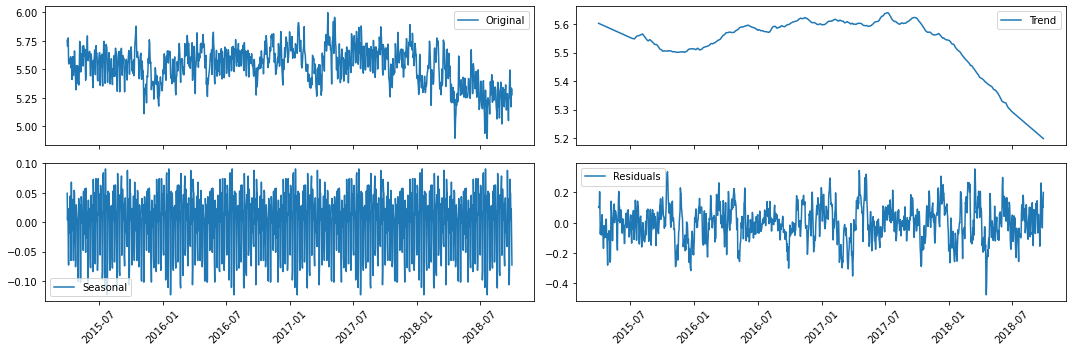

In [95]:
plot_decomposition(New_DF_training_OLS,'ts_log_minus_seasonal',trend='trend_2', seasonal='seasonal_2',residual='residuals_2')

In [96]:
New_DF_training_OLS['ts_log_minus_seasonal_again'] = New_DF_training_OLS['ts_log_minus_seasonal'] - New_DF_training_OLS['seasonal_2']

In [97]:
New_DF_training_OLS

,ds,ts,ts_log,trend,seasonal,residuals,index,ts_log_minus_seasonal,trend_2,seasonal_2,residuals_2,ts_log_minus_seasonal_again
ds,,,,,,,,,,,,
2015-04-01,2015-04-01,357.073,5.877940,5.558593,0.123204,0.196143,1,5.754736,5.602481,0.048987,0.103268,5.705749
2015-04-02,2015-04-02,341.931,5.834609,5.558451,0.129261,0.146897,2,5.705348,5.601928,0.003563,0.099857,5.701785
2015-04-03,2015-04-03,318.777,5.764492,5.558310,0.034810,0.171372,3,5.729682,5.601376,0.022850,0.105456,5.706831
2015-04-04,2015-04-04,312.494,5.744585,5.558168,-0.031844,0.218261,4,5.776429,5.600823,-0.029233,0.204840,5.805663
2015-04-05,2015-04-05,270.837,5.601517,5.558026,0.035628,0.007862,5,5.565889,5.600270,-0.072753,0.038372,5.638642
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-26,2018-09-26,172.802,5.152146,5.241861,-0.137478,0.047764,1275,5.289625,5.202595,0.048987,0.038043,5.240638
2018-09-27,2018-09-27,155.628,5.047469,5.240872,-0.123639,-0.069765,1276,5.171107,5.201549,0.003563,-0.034004,5.167544
2018-09-28,2018-09-28,182.789,5.208332,5.239882,-0.127714,0.096164,1277,5.336047,5.200502,0.022850,0.112695,5.313196


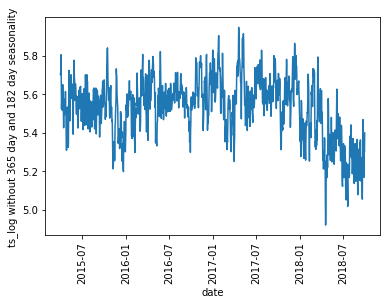

In [98]:
plt.xticks(rotation=90)
plt.xlabel('date')
plt.ylabel('ts_log without 365 day and 182 day seasonality')
plt.plot(New_DF_training_OLS['ds'], New_DF_training_OLS['ts_log_minus_seasonal_again'])

In [99]:
decomposition = seasonal_decompose(New_DF_training_OLS['ts_log_minus_seasonal_again'], period=7, extrapolate_trend=1)
New_DF_training_OLS.loc[:,'trend_3'] = decomposition.trend
New_DF_training_OLS.loc[:,'seasonal_3'] = decomposition.seasonal
New_DF_training_OLS.loc[:,'residuals_3'] = decomposition.resid

In [100]:
New_DF_training_OLS

,ds,ts,ts_log,trend,seasonal,residuals,index,ts_log_minus_seasonal,trend_2,seasonal_2,residuals_2,ts_log_minus_seasonal_again,trend_3,seasonal_3,residuals_3
ds,,,,,,,,,,,,,,,
2015-04-01,2015-04-01,357.073,5.877940,5.558593,0.123204,0.196143,1,5.754736,5.602481,0.048987,0.103268,5.705749,5.711222,0.000013,-0.005486
2015-04-02,2015-04-02,341.931,5.834609,5.558451,0.129261,0.146897,2,5.705348,5.601928,0.003563,0.099857,5.701785,5.695802,-0.000084,0.006067
2015-04-03,2015-04-03,318.777,5.764492,5.558310,0.034810,0.171372,3,5.729682,5.601376,0.022850,0.105456,5.706831,5.680381,-0.000291,0.026741
2015-04-04,2015-04-04,312.494,5.744585,5.558168,-0.031844,0.218261,4,5.776429,5.600823,-0.029233,0.204840,5.805663,5.664961,-0.000373,0.141075
2015-04-05,2015-04-05,270.837,5.601517,5.558026,0.035628,0.007862,5,5.565889,5.600270,-0.072753,0.038372,5.638642,5.649540,-0.000246,-0.010652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-26,2018-09-26,172.802,5.152146,5.241861,-0.137478,0.047764,1275,5.289625,5.202595,0.048987,0.038043,5.240638,5.324055,0.000013,-0.083429
2018-09-27,2018-09-27,155.628,5.047469,5.240872,-0.123639,-0.069765,1276,5.171107,5.201549,0.003563,-0.034004,5.167544,5.314114,-0.000084,-0.146486
2018-09-28,2018-09-28,182.789,5.208332,5.239882,-0.127714,0.096164,1277,5.336047,5.200502,0.022850,0.112695,5.313196,5.307953,-0.000291,0.005534


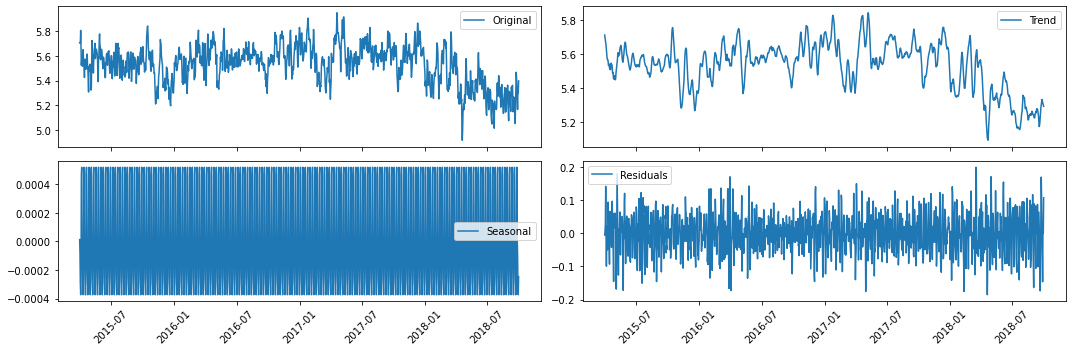

In [101]:
plot_decomposition(New_DF_training_OLS,'ts_log_minus_seasonal_again',trend='trend_3', seasonal='seasonal_3',residual='residuals_3')

In [102]:
New_DF_training_OLS['ts_log_minus_seasonal_again_again'] = New_DF_training_OLS['ts_log_minus_seasonal_again'] - New_DF_training_OLS['seasonal_3']

In [103]:
New_DF_training_OLS

,ds,ts,ts_log,trend,seasonal,residuals,index,ts_log_minus_seasonal,trend_2,seasonal_2,residuals_2,ts_log_minus_seasonal_again,trend_3,seasonal_3,residuals_3,ts_log_minus_seasonal_again_again
ds,,,,,,,,,,,,,,,,
2015-04-01,2015-04-01,357.073,5.877940,5.558593,0.123204,0.196143,1,5.754736,5.602481,0.048987,0.103268,5.705749,5.711222,0.000013,-0.005486,5.705737
2015-04-02,2015-04-02,341.931,5.834609,5.558451,0.129261,0.146897,2,5.705348,5.601928,0.003563,0.099857,5.701785,5.695802,-0.000084,0.006067,5.701869
2015-04-03,2015-04-03,318.777,5.764492,5.558310,0.034810,0.171372,3,5.729682,5.601376,0.022850,0.105456,5.706831,5.680381,-0.000291,0.026741,5.707122
2015-04-04,2015-04-04,312.494,5.744585,5.558168,-0.031844,0.218261,4,5.776429,5.600823,-0.029233,0.204840,5.805663,5.664961,-0.000373,0.141075,5.806035
2015-04-05,2015-04-05,270.837,5.601517,5.558026,0.035628,0.007862,5,5.565889,5.600270,-0.072753,0.038372,5.638642,5.649540,-0.000246,-0.010652,5.638888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-26,2018-09-26,172.802,5.152146,5.241861,-0.137478,0.047764,1275,5.289625,5.202595,0.048987,0.038043,5.240638,5.324055,0.000013,-0.083429,5.240625
2018-09-27,2018-09-27,155.628,5.047469,5.240872,-0.123639,-0.069765,1276,5.171107,5.201549,0.003563,-0.034004,5.167544,5.314114,-0.000084,-0.146486,5.167628
2018-09-28,2018-09-28,182.789,5.208332,5.239882,-0.127714,0.096164,1277,5.336047,5.200502,0.022850,0.112695,5.313196,5.307953,-0.000291,0.005534,5.313487


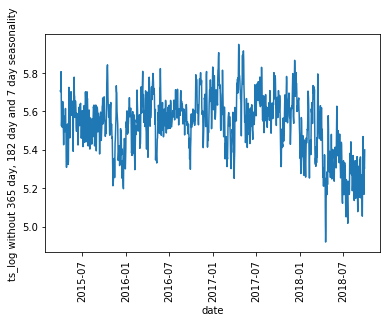

In [104]:
plt.xticks(rotation=90)
plt.xlabel('date')
plt.ylabel('ts_log without 365 day, 182 day and 7 day seasonality')
plt.plot(New_DF_training_OLS['ds'], New_DF_training_OLS['ts_log_minus_seasonal_again_again'])

In [105]:
decomposition = seasonal_decompose(New_DF_training_OLS['ts_log_minus_seasonal_again_again'], period=360, extrapolate_trend=1)
New_DF_training_OLS.loc[:,'trend_4'] = decomposition.trend
New_DF_training_OLS.loc[:,'seasonal_4'] = decomposition.seasonal
New_DF_training_OLS.loc[:,'residuals_4'] = decomposition.resid

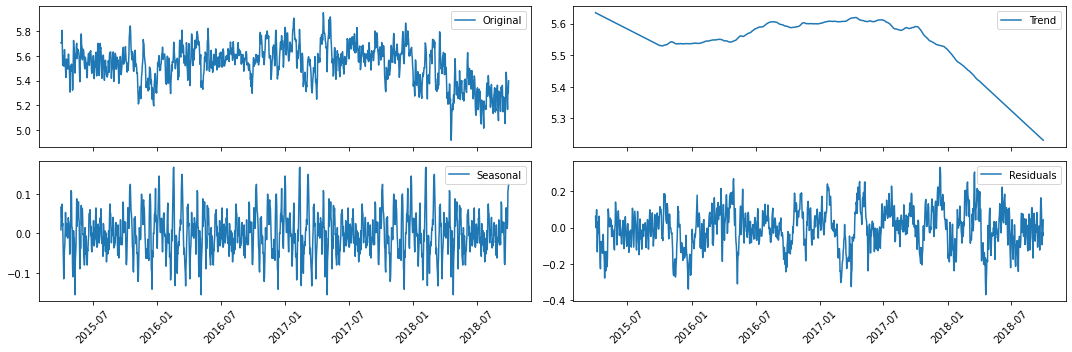

In [106]:
plot_decomposition(New_DF_training_OLS,'ts_log_minus_seasonal_again_again',trend='trend_4', seasonal='seasonal_4',residual='residuals_4')

# Curve fitting to the trend with 365, 182 and 7 day seasonalities removed

In [107]:
# turn 'index' column into a numpy array and make it the X for the trend with 365, 182 and 7 day seasonalities removed
X_new_trend = New_DF_training_OLS['index'].to_numpy()

In [108]:
# turn 'trend' column into a numpy array and make it the y for the trend with 365, 182 and 7 day seasonalities removed
y_new_trend = New_DF_training_OLS['trend_4'].to_numpy()

In [109]:
# do a polynomial fit of X values against y values for the new trend 
z_new_trend = np.polyfit(X_new_trend, y_new_trend, 5)

In [110]:
z_new_trend

array([ 7.86424536e-16, -1.67543631e-12, -3.95249765e-10,  2.03119581e-06,
       -8.77047728e-04,  5.64161280e+00])

In [111]:
p_new_trend = np.poly1d(z_new_trend)

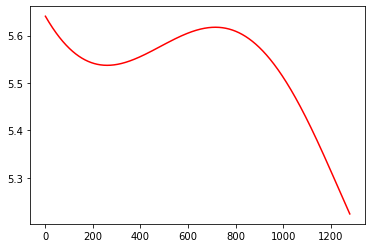

In [112]:
plt.plot(X_new_trend, p_new_trend(X), color='red')

<Figure size 432x288 with 0 Axes>

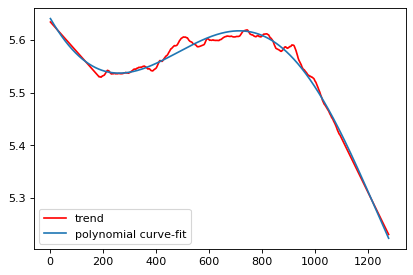

In [113]:
# plot the trend from the training set and overlap plot of the polyfit  
plt.figure()
plt.figure(figsize=(6, 4), dpi=80)
plot_1, = plt.plot(X_new_trend, y_new_trend, color='red', label ='trend')
plot_2, = plt.plot(X_new_trend, p_new_trend(X), label ='polynomial curve-fit')
plt.legend(handles=[plot_1, plot_2])
plt.show()

In [114]:
New_DF_training_OLS

,ds,ts,ts_log,trend,seasonal,residuals,index,ts_log_minus_seasonal,trend_2,seasonal_2,residuals_2,ts_log_minus_seasonal_again,trend_3,seasonal_3,residuals_3,ts_log_minus_seasonal_again_again,trend_4,seasonal_4,residuals_4
ds,,,,,,,,,,,,,,,,,,,
2015-04-01,2015-04-01,357.073,5.877940,5.558593,0.123204,0.196143,1,5.754736,5.602481,0.048987,0.103268,5.705749,5.711222,0.000013,-0.005486,5.705737,5.634260,0.009120,0.062357
2015-04-02,2015-04-02,341.931,5.834609,5.558451,0.129261,0.146897,2,5.705348,5.601928,0.003563,0.099857,5.701785,5.695802,-0.000084,0.006067,5.701869,5.633695,0.068016,0.000158
2015-04-03,2015-04-03,318.777,5.764492,5.558310,0.034810,0.171372,3,5.729682,5.601376,0.022850,0.105456,5.706831,5.680381,-0.000291,0.026741,5.707122,5.633130,0.040599,0.033393
2015-04-04,2015-04-04,312.494,5.744585,5.558168,-0.031844,0.218261,4,5.776429,5.600823,-0.029233,0.204840,5.805663,5.664961,-0.000373,0.141075,5.806035,5.632565,0.074408,0.099062
2015-04-05,2015-04-05,270.837,5.601517,5.558026,0.035628,0.007862,5,5.565889,5.600270,-0.072753,0.038372,5.638642,5.649540,-0.000246,-0.010652,5.638888,5.632000,0.018740,-0.011852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-26,2018-09-26,172.802,5.152146,5.241861,-0.137478,0.047764,1275,5.289625,5.202595,0.048987,0.038043,5.240638,5.324055,0.000013,-0.083429,5.240625,5.235096,0.012934,-0.007405
2018-09-27,2018-09-27,155.628,5.047469,5.240872,-0.123639,-0.069765,1276,5.171107,5.201549,0.003563,-0.034004,5.167544,5.314114,-0.000084,-0.146486,5.167628,5.234070,0.027593,-0.094035
2018-09-28,2018-09-28,182.789,5.208332,5.239882,-0.127714,0.096164,1277,5.336047,5.200502,0.022850,0.112695,5.313196,5.307953,-0.000291,0.005534,5.313487,5.233044,0.106610,-0.026167


## Run ARIMA on 'residuals_4' i.e. residuals that have had the 365 day, 182 day and 7 day seasonalities removed

C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


rmse: 0.051883241707735554


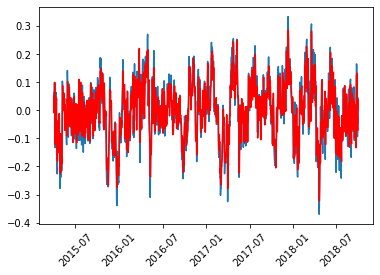

In [115]:
model_AR=run_Arima(df=New_DF_training_OLS,ts='residuals_4',p=23,d=0,q=0)

- Improved rmse on residuals_4 of 0.05188 with p=23, d=0 and q=0

- Improved rmse on residuals_4 of 0.04652 with p=150, d=0 and q=0

In [116]:
my_forecast_new = model_AR.forecast(274)

In [117]:
my_forecast_new

2018-10-01    0.059583
2018-10-02    0.050579
2018-10-03    0.001892
2018-10-04   -0.079700
2018-10-05   -0.088758
                ...   
2019-06-27   -0.002095
2019-06-28   -0.002107
2019-06-29   -0.002122
2019-06-30   -0.002128
2019-07-01   -0.002122
Freq: D, Name: predicted_mean, Length: 274, dtype: float64

<Figure size 432x288 with 0 Axes>

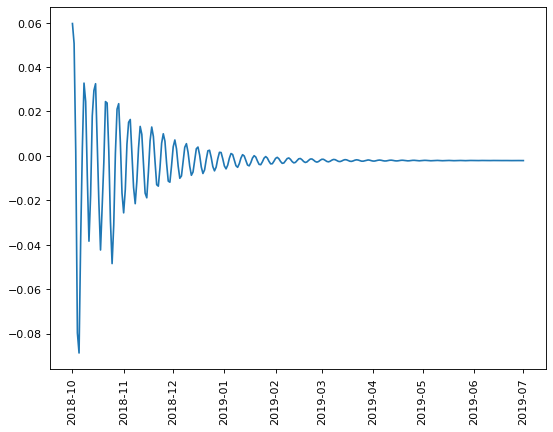

In [118]:
plt.figure()
plt.figure(figsize=(8, 6), dpi=80)
plt.xticks(rotation=90)
plt.plot(my_forecast_new)

In [119]:
# saving the ARIMA model of the log of the full signal
#model_AR.save('ARIMA_model_forecast_residuals(train=0.7pc, p=23, freq=365).pkl')

In [120]:
#load trained model 
#model_AR = ARIMAResults.load('ARIMA_model_forecast_residuals(train=0.7pc, p=150, freq=365).pkl')

# updated ARIMA residuals predictions

In [121]:
start = len(New_DF_training)
end = len(New_DF_training)+len(New_DF_validation)-1
pred_new = model_AR.predict(start=start, end=end).rename('ARIMA Predictions')
pred_DF_new = pd.DataFrame(pred_new)
pred_DF_new['Date']=pred_DF_new.index

In [125]:
# new ARIMA forecasts of residuals of consumption
pred_DF_new 

,ARIMA Predictions,Date
2018-10-01,0.059583,2018-10-01
2018-10-02,0.050579,2018-10-02
2018-10-03,0.001892,2018-10-03
2018-10-04,-0.079700,2018-10-04
2018-10-05,-0.088758,2018-10-05
...,...,...
2019-06-27,-0.002095,2019-06-27
2019-06-28,-0.002107,2019-06-28
2019-06-29,-0.002122,2019-06-29
2019-06-30,-0.002128,2019-06-30


In [126]:
sdate = '2018-10-01'
edate = '2019-07-01'
date_list = pd.date_range(sdate, edate, periods=274).tolist()

In [127]:
New_DF_validation

,ds,ts,ts_log,trend,seasonal,residuals
ds,,,,,,
2018-10-01,2018-10-01,201.030,5.303454,5.153987,0.006885,0.142582
2018-10-02,2018-10-02,226.232,5.421561,5.161311,0.014637,0.245613
2018-10-03,2018-10-03,207.030,5.332864,5.168635,0.000801,0.163428
2018-10-04,2018-10-04,180.827,5.197541,5.175959,0.021365,0.000217
2018-10-05,2018-10-05,160.632,5.079116,5.183283,0.021032,-0.125198
...,...,...,...,...,...,...
2019-06-27,2019-06-27,169.050,5.130195,4.928078,0.017844,0.184273
2019-06-28,2019-06-28,170.858,5.140833,4.921107,0.006885,0.212840
2019-06-29,2019-06-29,151.068,5.017730,4.914137,0.014637,0.088956


Text(0, 0.5, 'consumption')

<Figure size 432x288 with 0 Axes>

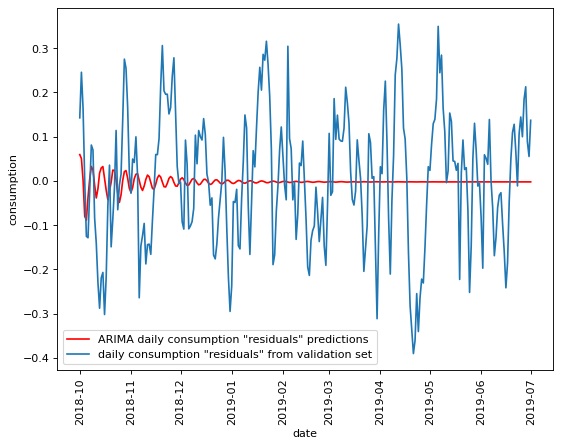

In [128]:
# plot ARIMA residuals forecast (with all the seasonality removed) and validation set residuals
plt.figure()
plt.figure(figsize=(8, 6), dpi=80)
plot_1, = plt.plot(date_list, pred_DF_new['ARIMA Predictions'], color='red', label ='ARIMA daily consumption "residuals" predictions')
plot_2, = plt.plot(date_list, New_DF_validation['residuals'], label ='daily consumption "residuals" from validation set')
plt.legend(handles=[plot_1, plot_2])
plt.xticks(rotation=90)
plt.xlabel("date")
plt.ylabel("consumption")
#plt.ylim([-0.3, 0.3])

In [129]:
# calculate rmse error between ARIMA residuals forecast and vaildation set residuals
rss = sum((pred_DF_new['ARIMA Predictions']-New_DF_validation['residuals'])**2)
rmse=np.sqrt(rss/len(New_DF_validation['residuals']))
print('rmse:',rmse)

rmse: 0.14791928168491125


# Combining new trend function with new ARIMA forecast on residuals with 4 sets of seasonalities which were subtracted

- Combining new trend function which does not contain 365 day, 182 day and 7 day seasonality (trend_4) with the new ARIMA forecast on residuals (which also does not contain 365 day, 182 day and 7 day seasonality) with 365 day seasonality (New_DF_training_OLS['seasonal']), 182 day seasonality (New_DF_training_OLS['seasonal_2']), 7 day seasonality (New_DF_training_OLS['seasonal_3']) and additional 360 day seasonality (New_DF_training_OLS['seasonal_4'])

In [130]:
# create the trend for the validation period from the polyfit coefficients generated from the training set
xp = np.linspace(0,274,274)
trend_new = p_new_trend(xp)

# add the trend to the pred_DF dataframe
pred_DF_new['trend'] = trend.tolist()

# extract the seasonalities for 365 days, 182 days, 7 days and 360 days from the training set i.e. the last 
# 274 rows of the training set and add them as columns
# to pred_DF
training_seasonal = New_DF_training_OLS['seasonal'].iloc[926:1200]
pred_DF_new['seasonal'] = training_seasonal.tolist()

training_seasonal_2 = New_DF_training_OLS['seasonal_2'].iloc[926:1200]
pred_DF_new['seasonal_2'] = training_seasonal_2.tolist()

training_seasonal_3 = New_DF_training_OLS['seasonal_3'].iloc[926:1200]
pred_DF_new['seasonal_3'] = training_seasonal_3.tolist()

training_seasonal_4 = New_DF_training_OLS['seasonal_4'].iloc[926:1200]
pred_DF_new['seasonal_4'] = training_seasonal_4.tolist()

In [131]:
pred_DF_new

,ARIMA Predictions,Date,trend,seasonal,seasonal_2,seasonal_3,seasonal_4
2018-10-01,0.059583,2018-10-01,5.557584,0.156632,0.038564,-0.000291,-0.086334
2018-10-02,0.050579,2018-10-02,5.557462,0.069083,-0.032708,-0.000373,-0.097964
2018-10-03,0.001892,2018-10-03,5.557340,-0.027953,-0.065187,-0.000246,-0.059825
2018-10-04,-0.079700,2018-10-04,5.557217,-0.055426,-0.005605,0.000463,0.037289
2018-10-05,-0.088758,2018-10-05,5.557094,0.026053,0.053924,0.000518,0.038640
...,...,...,...,...,...,...,...
2019-06-27,-0.002095,2019-06-27,5.538270,-0.467982,0.078405,0.000463,0.032360
2019-06-28,-0.002107,2019-06-28,5.538343,-0.459033,0.083763,0.000518,-0.014556
2019-06-29,-0.002122,2019-06-29,5.538417,-0.438166,0.039438,0.000013,-0.025602
2019-06-30,-0.002128,2019-06-30,5.538492,-0.356803,0.045289,-0.000084,-0.010411


In [133]:
# sum all the values from the trend, seasonal and ARIMA noise prediction
pred_DF_new['total_signal'] = pred_DF_new['ARIMA Predictions'] + pred_DF_new['trend'] + pred_DF_new['seasonal'] + pred_DF_new['seasonal_2'] + pred_DF_new['seasonal_3'] + pred_DF_new['seasonal_4']

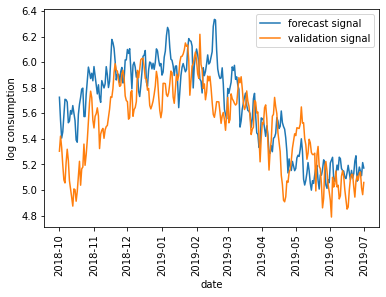

In [135]:
# plot the forecast signal along with the validation signal
plt.xticks(rotation=90)
plot_1, = plt.plot(pred_DF_new.Date, pred_DF_new.total_signal, label ='forecast signal')
plot_2, = plt.plot(New_DF_validation.ds, New_DF_validation.ts_log, label ='validation signal')
plt.xlabel('date')
plt.ylabel('log consumption')
plt.legend(handles=[plot_1, plot_2])

In [136]:
# calculate rmse error between forecast and vaildation 
rss = sum((pred_DF_new['total_signal']-New_DF_validation['ts_log'])**2)
rmse=np.sqrt(rss/len(New_DF_validation['ts_log']))
print('rmse:',rmse)

rmse: 0.28088634818751046


# Remove the trend from the orginial training signal and then do FFT

In [137]:
# create a copy of the 365 day decomposed training dataset and call it New_DF_training_trend
New_DF_training_trend = New_DF_training.copy()

In [138]:
# create a column called 'ts_log-trend' and populate it with values of the 'ts_log' minus 'trend'
New_DF_training_trend['ts_log-trend'] = New_DF_training_trend['ts_log'] - New_DF_training_trend['trend']

In [139]:
New_DF_training_trend

,ds,ts,ts_log,trend,seasonal,residuals,ts_log-trend
ds,,,,,,,
2015-04-01,2015-04-01,357.073,5.877940,5.558593,0.123204,0.196143,0.319347
2015-04-02,2015-04-02,341.931,5.834609,5.558451,0.129261,0.146897,0.276158
2015-04-03,2015-04-03,318.777,5.764492,5.558310,0.034810,0.171372,0.206182
2015-04-04,2015-04-04,312.494,5.744585,5.558168,-0.031844,0.218261,0.186417
2015-04-05,2015-04-05,270.837,5.601517,5.558026,0.035628,0.007862,0.043491
...,...,...,...,...,...,...,...
2018-09-26,2018-09-26,172.802,5.152146,5.241861,-0.137478,0.047764,-0.089714
2018-09-27,2018-09-27,155.628,5.047469,5.240872,-0.123639,-0.069765,-0.193403
2018-09-28,2018-09-28,182.789,5.208332,5.239882,-0.127714,0.096164,-0.031550


In [140]:
decomposition = seasonal_decompose(New_DF_training_trend['ts_log-trend'], period=365, extrapolate_trend=1)
New_DF_training_trend.loc[:,'trend_1'] = decomposition.trend
New_DF_training_trend.loc[:,'seasonal_1'] = decomposition.seasonal
New_DF_training_trend.loc[:,'residuals_1'] = decomposition.resid

In [141]:
New_DF_training_trend

,ds,ts,ts_log,trend,seasonal,residuals,ts_log-trend,trend_1,seasonal_1,residuals_1
ds,,,,,,,,,,
2015-04-01,2015-04-01,357.073,5.877940,5.558593,0.123204,0.196143,0.319347,0.009386,0.123571,0.186390
2015-04-02,2015-04-02,341.931,5.834609,5.558451,0.129261,0.146897,0.276158,0.009278,0.129655,0.137225
2015-04-03,2015-04-03,318.777,5.764492,5.558310,0.034810,0.171372,0.206182,0.009171,0.035518,0.161493
2015-04-04,2015-04-04,312.494,5.744585,5.558168,-0.031844,0.218261,0.186417,0.009064,-0.031085,0.208438
2015-04-05,2015-04-05,270.837,5.601517,5.558026,0.035628,0.007862,0.043491,0.008956,0.036324,-0.001790
...,...,...,...,...,...,...,...,...,...,...
2018-09-26,2018-09-26,172.802,5.152146,5.241861,-0.137478,0.047764,-0.089714,-0.004996,-0.138497,0.053778
2018-09-27,2018-09-27,155.628,5.047469,5.240872,-0.123639,-0.069765,-0.193403,-0.005027,-0.124847,-0.063529
2018-09-28,2018-09-28,182.789,5.208332,5.239882,-0.127714,0.096164,-0.031550,-0.005059,-0.128913,0.102422


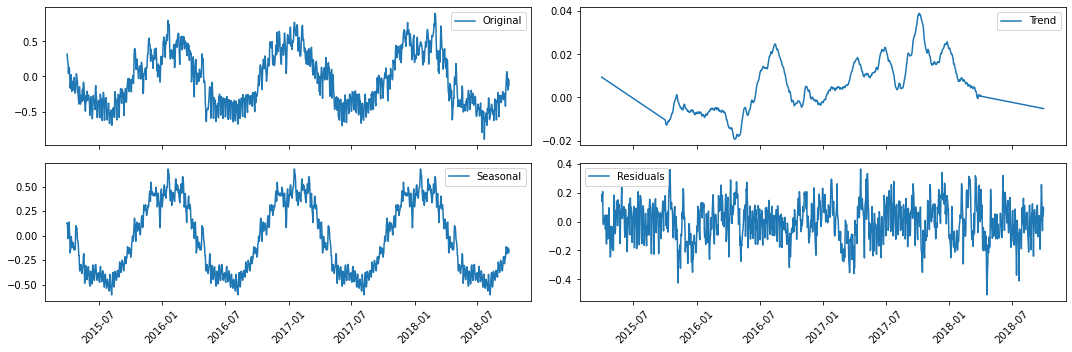

In [142]:
plot_decomposition(New_DF_training_trend,'ts_log-trend',trend='trend_1', seasonal='seasonal_1',residual='residuals_1')

# fft on this 'ts_log-trend' 

In [143]:
# reset the index of the training set copy
New_DF_training_trend.reset_index(drop=True, inplace=True)

In [144]:
# create a separate column called index which is the index of the training set copy
New_DF_training_trend['index'] = New_DF_training_trend.index

In [145]:
# add 1 to each term in the index column
New_DF_training_trend['index'] += 1

In [146]:
# add 1 to each term in the index column
New_DF_training_trend.index = New_DF_training_trend['ds']

In [147]:
y_trend = New_DF_training_trend['ts_log-trend'].to_numpy()
x_trend = New_DF_training_trend['index'].to_numpy()

In [148]:
New_DF_training_trend

,ds,ts,ts_log,trend,seasonal,residuals,ts_log-trend,trend_1,seasonal_1,residuals_1,index
ds,,,,,,,,,,,
2015-04-01,2015-04-01,357.073,5.877940,5.558593,0.123204,0.196143,0.319347,0.009386,0.123571,0.186390,1
2015-04-02,2015-04-02,341.931,5.834609,5.558451,0.129261,0.146897,0.276158,0.009278,0.129655,0.137225,2
2015-04-03,2015-04-03,318.777,5.764492,5.558310,0.034810,0.171372,0.206182,0.009171,0.035518,0.161493,3
2015-04-04,2015-04-04,312.494,5.744585,5.558168,-0.031844,0.218261,0.186417,0.009064,-0.031085,0.208438,4
2015-04-05,2015-04-05,270.837,5.601517,5.558026,0.035628,0.007862,0.043491,0.008956,0.036324,-0.001790,5
...,...,...,...,...,...,...,...,...,...,...,...
2018-09-26,2018-09-26,172.802,5.152146,5.241861,-0.137478,0.047764,-0.089714,-0.004996,-0.138497,0.053778,1275
2018-09-27,2018-09-27,155.628,5.047469,5.240872,-0.123639,-0.069765,-0.193403,-0.005027,-0.124847,-0.063529,1276
2018-09-28,2018-09-28,182.789,5.208332,5.239882,-0.127714,0.096164,-0.031550,-0.005059,-0.128913,0.102422,1277


In [149]:
# FFT on ts_log
yf_trend = fft(y_trend)
yf_trend.shape

(1279,)

In [150]:
# take the index, with periodicity of 1 day, and use to calculate the fft frequency but for half of the total 
# signal period since the signal is repeating
N_trend = x_trend.size
T_trend = x_trend[1] - x_trend[0]
xf1_trend = fftfreq(N_trend, T_trend)
xf2_trend = fftfreq(N_trend, T_trend)[0:N_trend//2]

In [151]:
# take half the fft(y) values (since fft signal is symetrical about x=0 ) and then multiply the half of the fft(y)
# values by 1/hlaf of the total signal period
zf_trend = 2.0/N_trend * np.abs(yf_trend[0:N_trend//2])
#zf =  np.abs(yf[0:N//2])

In [152]:
plt.figure(figsize=(10, 4))
plt.plot(xf2_trend, zf_trend)
plt.xlabel('frequency')
plt.ylabel('fft(y)')
plt.ylim((0, 0.35))
plt.xlim((0, 0.45))
mpld3.display()

# Test case

## ARIMA test predictions

In [175]:
start = len(New_DF_training)+len(New_DF_validation)
start

1553

In [176]:
end = len(New_DF_training)+len(New_DF_validation)+len(df_test)-1
end

1826

In [177]:
pred_test = model_AR.predict(start=start, end=end).rename('ARIMA Predictions')
pred_test_DF = pd.DataFrame(pred_test)
pred_test_DF['Date']=pred_test_DF.index

In [178]:
pred_test_DF

,ARIMA Predictions,Date
2019-07-02,-0.002108,2019-07-02
2019-07-03,-0.002098,2019-07-03
2019-07-04,-0.002099,2019-07-04
2019-07-05,-0.002109,2019-07-05
2019-07-06,-0.002121,2019-07-06
...,...,...
2020-03-27,-0.002112,2020-03-27
2020-03-28,-0.002112,2020-03-28
2020-03-29,-0.002112,2020-03-29
2020-03-30,-0.002112,2020-03-30


In [179]:
sdate = '2019-07-02'
edate = '2020-03-31'
date_list = pd.date_range(sdate, edate, periods=274).tolist()

In [180]:
pred_test_DF

,ARIMA Predictions,Date
2019-07-02,-0.002108,2019-07-02
2019-07-03,-0.002098,2019-07-03
2019-07-04,-0.002099,2019-07-04
2019-07-05,-0.002109,2019-07-05
2019-07-06,-0.002121,2019-07-06
...,...,...
2020-03-27,-0.002112,2020-03-27
2020-03-28,-0.002112,2020-03-28
2020-03-29,-0.002112,2020-03-29
2020-03-30,-0.002112,2020-03-30


In [181]:
# create the trend for the validation period from the polyfit coefficients generated from the training set
xp = np.linspace(275,549,274)
trend_new = p_new_trend(xp)

# add the trend to the pred_DF dataframe
pred_test_DF['trend'] = trend.tolist()

# extract the seasonalities for 365 days, 182 days, 7 days and 360 days from the training set i.e. the last 
# 274 rows of the training set and add them as columns
# to pred_DF
training_seasonal = New_DF_training_OLS['seasonal'].iloc[806:1080]
pred_test_DF['seasonal'] = training_seasonal.tolist()

training_seasonal_2 = New_DF_training_OLS['seasonal_2'].iloc[806:1080]
pred_test_DF['seasonal_2'] = training_seasonal_2.tolist()

training_seasonal_3 = New_DF_training_OLS['seasonal_3'].iloc[806:1080]
pred_test_DF['seasonal_3'] = training_seasonal_3.tolist()

training_seasonal_4 = New_DF_training_OLS['seasonal_4'].iloc[806:1080]
pred_test_DF['seasonal_4'] = training_seasonal_4.tolist()

In [182]:
# sum all the values from the trend, seasonal and ARIMA noise prediction
pred_test_DF['total_signal'] = pred_test_DF['ARIMA Predictions'] + pred_test_DF['trend'] + pred_test_DF['seasonal'] + pred_test_DF['seasonal_2'] + pred_test_DF['seasonal_3'] + pred_test_DF['seasonal_4']

In [183]:
pred_test_DF

,ARIMA Predictions,Date,trend,seasonal,seasonal_2,seasonal_3,seasonal_4,total_signal
2019-07-02,-0.002108,2019-07-02,5.557584,-0.301450,0.000114,-0.000084,0.017678,5.271734
2019-07-03,-0.002098,2019-07-03,5.557462,-0.370626,0.049586,-0.000291,-0.033610,5.200424
2019-07-04,-0.002099,2019-07-04,5.557340,-0.428025,-0.070511,-0.000373,-0.046739,5.009594
2019-07-05,-0.002109,2019-07-05,5.557217,-0.456956,-0.070590,-0.000246,-0.002928,5.024387
2019-07-06,-0.002121,2019-07-06,5.557094,-0.386087,0.072844,0.000463,0.000302,5.242495
...,...,...,...,...,...,...,...,...
2020-03-27,-0.002112,2020-03-27,5.538270,0.227116,-0.074226,-0.000246,-0.099474,5.589327
2020-03-28,-0.002112,2020-03-28,5.538343,0.129659,0.023450,0.000463,-0.133229,5.556574
2020-03-29,-0.002112,2020-03-29,5.538417,0.296900,0.041252,0.000518,-0.081666,5.793309
2020-03-30,-0.002112,2020-03-30,5.538492,0.276320,0.002180,0.000013,-0.059186,5.755708


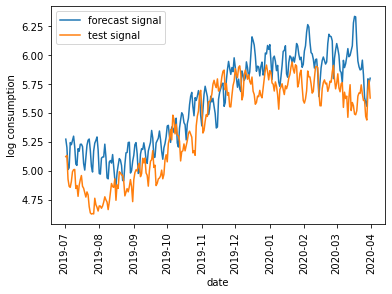

In [184]:
# plot the forecast signal along with the validation signal
plt.xticks(rotation=90)
plot_1, = plt.plot(pred_test_DF.Date, pred_test_DF.total_signal, label ='forecast signal')
plot_2, = plt.plot(df_test.ds, df_test.ts_log, label ='test signal')
plt.xlabel('date')
plt.ylabel('log consumption')
plt.legend(handles=[plot_1, plot_2])

In [185]:
# calculate rmse error between forecast and vaildation 
rss = sum((pred_test_DF['total_signal']-df_test['ts_log'])**2)
rmse=np.sqrt(rss/len(df_test['ts_log']))
print('rmse:',rmse)

rmse: 0.27441921016543935


# 12 month forecast

In [186]:
my_forecast_12_months = model_AR.forecast(365)

In [187]:
my_forecast_12_months

2018-10-01    0.059583
2018-10-02    0.050579
2018-10-03    0.001892
2018-10-04   -0.079700
2018-10-05   -0.088758
                ...   
2019-09-26   -0.002112
2019-09-27   -0.002113
2019-09-28   -0.002113
2019-09-29   -0.002112
2019-09-30   -0.002111
Freq: D, Name: predicted_mean, Length: 365, dtype: float64

In [198]:
# In the dataset provided (energy.dat) there are 1827 rows. The last row number is 1826
# Hence to build a 12 month forecast, set forecast row values from 1827 to 2191 i.e. 365 days
pred_12_month = model_AR.predict(start=1827, end=2191).rename('ARIMA Predictions')
pred_12_month_DF = pd.DataFrame(pred_12_month)
pred_12_month_DF['Date']=pred_12_month_DF.index

In [199]:
sdate = '2020-04-01'
edate = '2021-03-31'
date_list = pd.date_range(sdate, edate, periods=365).tolist()

In [200]:
pred_12_month_DF

,ARIMA Predictions,Date
2020-04-01,-0.002112,2020-04-01
2020-04-02,-0.002112,2020-04-02
2020-04-03,-0.002112,2020-04-03
2020-04-04,-0.002112,2020-04-04
2020-04-05,-0.002112,2020-04-05
...,...,...
2021-03-27,-0.002112,2021-03-27
2021-03-28,-0.002112,2021-03-28
2021-03-29,-0.002112,2021-03-29
2021-03-30,-0.002112,2021-03-30


In [201]:
# create the trend for the validation period from the polyfit coefficients generated from the training set
xp = np.linspace(0,365,365)
trend_new = p_new_trend(xp)

# add the trend to the pred_DF dataframe
pred_12_month_DF['trend'] = trend_new.tolist()

# extract the seasonalities for 365 days, 182 days, 7 days and 360 days from the training set i.e. the last 
# 274 rows of the training set and add them as columns
# to pred_DF
training_seasonal = New_DF_training_OLS['seasonal'].iloc[730:1095]
pred_12_month_DF['seasonal'] = training_seasonal.tolist()

training_seasonal_2 = New_DF_training_OLS['seasonal_2'].iloc[730:1095]
pred_12_month_DF['seasonal_2'] = training_seasonal_2.tolist()

training_seasonal_3 = New_DF_training_OLS['seasonal_3'].iloc[730:1095]
pred_12_month_DF['seasonal_3'] = training_seasonal_3.tolist()

training_seasonal_4 = New_DF_training_OLS['seasonal_4'].iloc[730:1095]
pred_12_month_DF['seasonal_4'] = training_seasonal_4.tolist()

In [202]:
# sum all the values from the trend, seasonal and ARIMA noise prediction
pred_12_month_DF['total_signal'] = pred_12_month_DF['ARIMA Predictions'] + pred_12_month_DF['trend'] + pred_12_month_DF['seasonal'] + pred_12_month_DF['seasonal_2'] + pred_12_month_DF['seasonal_3'] + pred_12_month_DF['seasonal_4']

In [203]:
pred_12_month_DF

,ARIMA Predictions,Date,trend,seasonal,seasonal_2,seasonal_3,seasonal_4,total_signal
2020-04-01,-0.002112,2020-04-01,5.641613,0.123204,0.022850,-0.000291,-0.041481,5.743784
2020-04-02,-0.002112,2020-04-02,5.640735,0.129261,-0.029233,-0.000373,-0.029210,5.709069
2020-04-03,-0.002112,2020-04-03,5.639862,0.034810,-0.072753,-0.000246,0.002445,5.602006
2020-04-04,-0.002112,2020-04-04,5.638993,-0.031844,0.023149,0.000463,0.053331,5.681979
2020-04-05,-0.002112,2020-04-05,5.638128,0.035628,-0.018180,0.000518,0.025332,5.679314
...,...,...,...,...,...,...,...,...
2021-03-27,-0.002112,2021-03-27,5.547476,0.066214,0.072713,0.000463,-0.041481,5.643272
2021-03-28,-0.002112,2021-03-28,5.547663,0.123062,0.051702,0.000518,-0.029210,5.691624
2021-03-29,-0.002112,2021-03-29,5.547852,0.139341,0.048987,0.000013,0.002445,5.736525
2021-03-30,-0.002112,2021-03-30,5.548043,0.165761,0.003563,-0.000084,0.053331,5.768502


In [204]:
def exp_trans(df,ts): return df[ts].apply(lambda x:np.exp(x))

In [205]:
pred_12_month_DF['ts']=exp_trans(pred_12_month_DF,'total_signal')

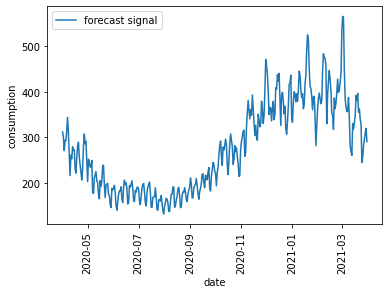

In [207]:
# plot the forecast signal along with the validation signal
plt.xticks(rotation=90)
plot_1, = plt.plot(pred_12_month_DF.Date, pred_12_month_DF.ts, label ='forecast signal')
plt.xlabel('date')
plt.ylabel('consumption')
plt.legend(handles=[plot_1])